#Modeling & Active Learning.ipynb

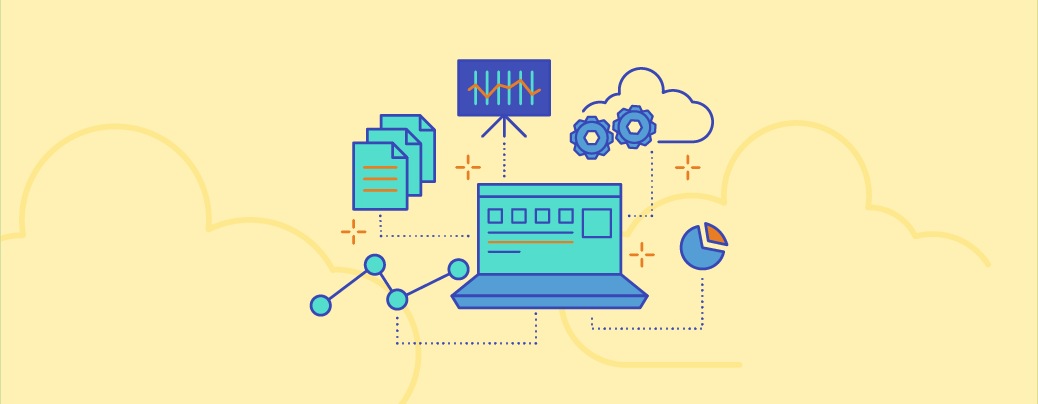





##Objective

*   The expected outputs are preliminary models, and the one that offers the best performance in the considered metrics will be chosen for use in the first production version.


# As we are building a game recommendation solution, the metrics chosen were:

- ROC AUC:  It tells how much the model is capable of distinguishing between classes. Higher the AUC, the better the model is at predicting 0 classes as 0 and 1 classes as 1.

- Average Precision: Average precision indicates whether your model can correctly identify all the positive examples without accidentally marking too many negative examples as positive. Thus, average precision is high when our model can correctly handle positives (recommended games)



# 1. Library imports

In [ ]:
import pandas as pd
import numpy as np
import re
import time

import bs4 as bs4
import json

import glob
import tqdm

#https://strftime.org/
%matplotlib inline
%pylab inline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.tree import plot_tree
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack, vstack
from sklearn.linear_model import LogisticRegression from sklearn.ensemble import RandomForestClassifie


Populating the interactive namespace from numpy and matplotlib


#Model 1 - Decision Tree 



*   In this first model, only two features will be used: the note from specialized critics and users



In [ ]:
features1 = pd.DataFrame(index=df_limpo_nonull.index)
y = df_limpo_nonull['y'].copy()

In [ ]:
features1['userscore'] = df_limpo_nonull['userscore'].astype(float)
features1['metascore'] = df_limpo_nonull['metascore'].astype(float)



*  Splitting the dataset between training and testing



In [ ]:
mdl = DecisionTreeClassifier(random_state=0, max_depth=2, class_weight="balanced")
mdl.fit(X_train, y_train)

In [ ]:
p = mdl.predict_proba(X_test)[:, 1]



*   Model performance.



In [ ]:
average_precision_score(y_test, p)

0.799211387515071

In [ ]:
roc_auc_score(y_test, p)

0.955986878075451



*   The figure below allows us to visualize the behavior of the model in the face of segmentation in the features.



[Text(0.4, 0.8333333333333334, 'metascore <= 67.0\ngini = 0.5\nsamples = 306\nvalue = [153.0, 153.0]'),
 Text(0.2, 0.5, 'gini = 0.0\nsamples = 184\nvalue = [141.467, 0.0]'),
 Text(0.6, 0.5, 'userscore <= 7.45\ngini = 0.13\nsamples = 122\nvalue = [11.533, 153.0]'),
 Text(0.4, 0.16666666666666666, 'gini = 0.334\nsamples = 15\nvalue = [3.844, 14.299]'),
 Text(0.8, 0.16666666666666666, 'gini = 0.1\nsamples = 107\nvalue = [7.688, 138.701]')]

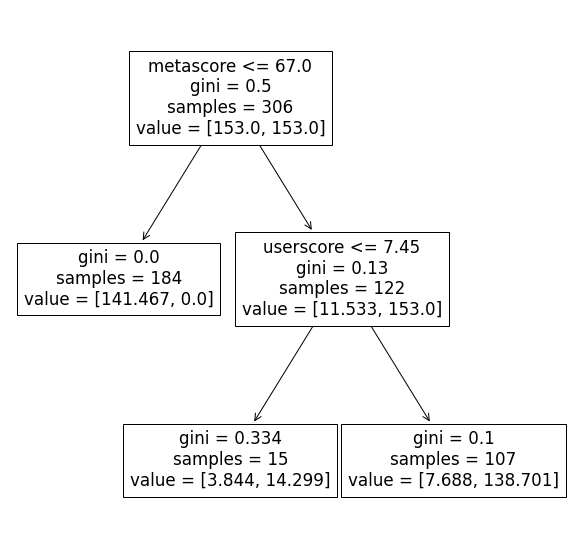

In [ ]:
fig, ax = pylab.subplots(1,1, figsize=(10,10))
plot_tree(mdl, ax=ax, feature_names=X_train.columns)

# Model 2 - Random Forest + TfidfVectorizer


*    The initial steps were constructed in a similar way to the previous model.

In [ ]:
features2 = pd.DataFrame(index=df_limpo_nonull.index)
y = df_limpo_nonull['y'].copy()

In [ ]:
features2['userscore'] = df_limpo_nonull['userscore'].astype(float)
features2['metascore'] = df_limpo_nonull['metascore'].astype(float)

In [ ]:
features2.head()

,userscore,metascore
0,9.1,99.0
1,7.4,98.0
2,8.2,97.0
3,8.3,94.0
4,9.2,94.0


In [ ]:
features2.dtypes

userscore    float64
metascore    float64
dtype: object

In [ ]:
mask_train =  df_limpo_nonull['release_data'] < "2009-06-01"
mask_val =  df_limpo_nonull['release_data'] >= "2009-06-01"

Xtrain, Xval = features2[mask_train], features2[mask_val]
ytrain, yval = y[mask_train], y[mask_val]
Xtrain.shape, Xval.shape, ytrain.shape, yval.shape

((306, 2), (239, 2), (306,), (239,))

A notable difference from this model is the use of the "developer" column. For this variable, **TfidfVectorizer()** was used, present in sklearn. 

This transformer builds a Bag of Words (BoW), but instead of directly counting the exact value of how many words are in that string, as is done with CountVectorizer(), it uses an **approach that takes into account the frequency of that word in all the examples and guarantees a higher value for the "rare" ones and a lower value for the common ones.**

In [ ]:
developer_train = df_limpo_nonull[mask_train]['developer']
developer_val = df_limpo_nonull[mask_val]['developer']
developer_val = developer_val.drop(developer_val.index[[2,11,21,27,28,31,33,35,37,40,41,44,15,49,50,51,52,53,64,68,69,70,71,73,76,79,82,85,86,87,88,93,94]], axis = 0)
Xval = Xval.drop(Xval.index[[2,11,21,27,28,31,33,35,37,40,41,44,15,49,50,51,52,53,64,68,69,70,71,73,76,79,82,85,86,87,88,93,94]], axis = 0)
yval = yval.drop(yval.index[[2,11,21,27,28,31,33,35,37,40,41,44,15,49,50,51,52,53,64,68,69,70,71,73,76,79,82,85,86,87,88,93,94]], axis = 0)
developer_vec = TfidfVectorizer(min_df=1)

#BoW usually has a sparse structure because it has many null values, so it is saved as a sparse array.

developer_bow_train = developer_vec.fit_transform(developer_train)
developer_bow_val = developer_vec.transform(developer_val)


The main advantage of this method is that words that occur very frequently are usually of less importance and end up "receiving" a more irrelevant value in our BoW, leaving more space for features that appear only in certain groups of our examples and tend to have a higher predictive value.



*   To join the BoW, which is a sparse matrix, with our dataset we used the scipy hstack function, which performs the horizontal join of these two datasets.



In [ ]:
Xtrain_wdeveloper = hstack([Xtrain, developer_bow_train])
Xval_wdeveloper = hstack([Xval, developer_bow_val])

For the evaluation, a Random Forest Vanilla is used, which has common values ​​of the hyperparameters. The class_weight=1 is used because we are dealing with unbalanced data, so this argument proposes to compensate for this fact by giving more "importance" to the less frequent values

In [ ]:
mdl = RandomForestClassifier(n_estimators=1000, random_state=0, class_weight="balanced", n_jobs=6)
mdl.fit(Xtrain_wdeveloper, ytrain)

RandomForestClassifier(class_weight='balanced', n_estimators=1000, n_jobs=6,
                       random_state=0)

In [ ]:
p = mdl.predict_proba(Xval_wdeveloper)[:, 1]

In [ ]:
average_precision_score(yval, p)

0.8581170891121374

In [ ]:
roc_auc_score(yval, p)

0.9642261904761904

There is a superior performance compared to the previous model, which is consistent with what was expected after all Random Forest is a more robust model.

# Model 3 - Active learning

###In order to simulate a real project, in which specialists would be needed to annotate our data and considering that this process was costly for the company, we decided to simulate the Active Learning methodology.

###Before we go any further, we have to import new examples and clean them up

In [ ]:
df_unlabeled = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Projetos/Recomendação jogos/games_raw_data_with_labels.csv", index_col=0)
df_unlabeled = df_unlabeled[df_unlabeled['y'].isnull()].dropna(how='all')
df_unlabeled.shape

(217, 10)

In [ ]:
df_limpo_u = pd.DataFrame(index=df_unlabeled.index)

In [ ]:
df_unlabeled.head(1)

,product_title,y,metascore_wrap_highlight_metascore,userscore_wrap_feature_userscore,summary_detail_publisher,summary_detail_developer,summary_detail_release_data,summary_detail_product_genre,summary_detail_product_players,summary_detail_product_rating
103,Naughty Bear\nPlayStation 3,NaN,Metascore\n43\nGenerally unfavorable reviews\n...,User Score\n5.8\n\nMixed or average reviews- b...,Publisher:\n505 Games,Developer:\n\nArtificial Mind and Movement,"Release Date:\nJun 25, 2010","Genre(s): Action, General, General",# of players:\nUp to 4,Rating:\nT


In [ ]:
#date

release = df_unlabeled['summary_detail_release_data'].str.extract(r"((?<=Release Date:\n).*)", expand=False)
df_limpo_u['release_data'] = pd.to_datetime(release, format="%b %d, %Y")

#tittle
#busca tudo na linha até \n

titulo = df_unlabeled['product_title'].str.extract("([^\n]*)", expand=False)
df_limpo_u['tittle'] = titulo

#userscore
score_user = df_unlabeled['userscore_wrap_feature_userscore'].str.extract("(\w\.\w)", expand=False)
df_limpo_u['userscore'] = score_user

#metascore
score_meta = df_unlabeled['metascore_wrap_highlight_metascore'].str.extract("((?<=Metascore\n).*)", expand=False)
df_limpo_u['metascore'] = score_meta

#genre
genre = df_unlabeled['summary_detail_product_genre'].str.extract(r"((?<= )[^/]+)", expand=False)
df_limpo_u['genre'] = genre

#developer
dev = df_unlabeled['summary_detail_developer'].str.extract(r"((?<=Developer:\n\n).*)", expand=False)
df_limpo_u['developer'] = dev

#publisher
pub = df_unlabeled['summary_detail_publisher'].str.extract("((?<=Publisher:\n).*)", expand=False)
df_limpo_u['publisher'] = pub

#rating
rat = df_unlabeled['summary_detail_product_rating'].str.extract("((?<=Rating:\n).*)", expand=False)
df_limpo_u['rating'] = rat

df_limpo_u = df_limpo_u.dropna()

In [ ]:
df_limpo_u.head(100)

,release_data,tittle,userscore,metascore,genre,developer,publisher,rating
103,2010-06-25,Naughty Bear,5.8,43,"Action, General, General",Artificial Mind and Movement,505 Games,T
104,2008-03-12,Bliss Island,7.0,43,"Miscellaneous, Puzzle, Puzzle, General, General",Pompom Software,Codemasters,E
106,2014-06-24,The Good Life,4.3,43,"Action Adventure, Sci-Fi, General",Edge of Reality,Activision,T
107,2015-01-09,Trophy,4.3,43,"Action, Platformer, 2D",A Crowd of Monsters,A Crowd of Monsters,T
108,2016-11-16,Babylon's Fall,2.1,43,"Tycoon, Strategy, Management, Business",Nvizzio Creations,Atari,E
...,...,...,...,...,...,...,...,...
477,2009-09-30,Valhalla Knights: Eldar Saga,6.9,35,"Role-Playing, General, General, Action RPG","K2, Kurogane",XSEED Games,T
478,2018-03-06,Babylon's Fall,6.8,35,"Adventure, Visual Novel",RLR Training Inc,RLR Training Inc,M
479,2003-11-18,Fugitive Hunter: War on Terror,5.0,35,"Action, Shooter, First-Person, Modern",Black Ops Entertainment,"Encore Software, Inc.",M
480,2011-05-11,Star Raiders,5.0,35,"Action, Simulation, General, Sci-Fi, Space, Sm...",Incinerator Games,Atari,E10+


In [ ]:
df_limpo_u.shape

(206, 8)

In [ ]:
features3 = pd.DataFrame(index=df_limpo_u.index)
features3['userscore'] = df_limpo_u['userscore'].astype(float)
features3['metascore'] = df_limpo_u['metascore'].astype(float)

In [ ]:
features3.head()

,userscore,metascore
103,5.8,43.0
104,7.0,43.0
106,4.3,43.0
107,4.3,43.0
108,2.1,43.0


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

developer_u = df_limpo_u['developer']
developer_bow_u = developer_vec.transform(developer_u)


In [ ]:
Xu_wdeveloper = hstack([features3, developer_bow_u])

In [ ]:
pu = mdl.predict_proba(Xu_wdeveloper)[:, 1]

In [ ]:
pu.shape

(206,)

In [ ]:
df_limpo_u['p']  = pu

In [ ]:
mask_u0 = (df_limpo_u['p'] >= 0.4) & (df_limpo_u['p'] <= 0.6)

In [ ]:
df_limpo_u[mask_u0].to_csv("active_label1.csv")

With the file obtained above, the manual labeling will be done

### Joining datasets


Importing the new dataframe with the selected examples and with the labeling done

In [ ]:
df_act = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Projetos/Recomendação jogos/active_label_with_y.csv", index_col=0)
df_act = df_act[df_act['y'].notnull()]
df_act.shape

In [ ]:
#joining dataframes

dfa = pd.concat([df_limpo, df_act.drop("p", axis=1)]) 

In [ ]:
dfa = dfa.dropna()



*   The next steps are similar to those previously performed in model 2, the difference is that now our training will be done with the data selected by active learning.



In [ ]:
dfy = dfa
dfa = dfa.drop(['y'], axis=1)

In [ ]:
####features
features4 = pd.DataFrame(index=dfa.index)
features4['userscore'] = dfa['userscore'].astype(float)
features4['metascore'] = dfa['metascore'].astype(float)
features4['developer'] = dfa['developer']

In [ ]:
X = features4
y = dfy['y']

# 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, shuffle=True)


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

#
devv_train = X_train['developer'].values.astype('U')
devv_val = X_test['developer'].values.astype('U')

#
X_train = X_train.drop("developer", axis=1)
X_test = X_test.drop("developer", axis=1)

devv_vec = TfidfVectorizer(min_df=2)

#>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
devv_bow_train = devv_vec.fit_transform(devv_train)
devv_bow_val = devv_vec.transform(devv_val)

In [ ]:
#Saving the vectorizer to be used in production later
pickle.dump(devv_vec, open("vectorizer.pickle", "wb")) 

In [ ]:
from scipy.sparse import hstack, vstack

#joining
Xtrain_wtitle = hstack([X_train, devv_bow_train])
Xval_wtitle = hstack([X_test, devv_bow_val])

In [ ]:
Xtrain_wtitle.shape, Xval_wtitle.shape

((429, 135), (143, 135))

In [ ]:
mdl = RandomForestClassifier(n_estimators=1000, random_state=0, class_weight="balanced", n_jobs=6)
mdl.fit(Xtrain_wtitle, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=1000, n_jobs=6,
                       random_state=0)

In [ ]:
p = mdl.predict_proba(Xval_wtitle)[:, 1]

In [ ]:
average_precision_score(y_test, p), roc_auc_score(y_test, p)

(0.9267148946808588, 0.9781910009182737)

##Saving Model

In [ ]:
import pickle 


In [ ]:
filename = "trained_model.pkl"
pickle.dump(mdl, open(filename,'wb'))

In [ ]:
#save pickle
pickle.dump(developer_vec, open("vectorizer1.pickle", "wb")) 

In [ ]:
filename = "games_model2.pkl"
pickle.dump(mdl, open(filename,'wb'))